In [159]:
import pandas as pd
import numpy as np
from joblib import load
import seaborn as sns
from matplotlib import pyplot as plt 
from tqdm.notebook import tqdm

In [201]:
#for the driver scheduling problem (aka how many drivers we need per )
mm = load('minimum_active_uber_trips')
print('Minute Range:', mm.index.max())
mm.head(3)

Minute Range: 1439


,Driver Count,Hour
Minute,,
0,5161.489796,0.0
1,5060.322751,0.0
2,5076.383838,0.0


In [192]:
#generate bundles of 1k drivers at once, with their interval lengths and centers
#interval length from 2 - 10 hours (120 - 600 minutes)
#centers from 0 - 1439

def generate_bundle(size = 1000):
    centers = np.random.randint(1440, size = size)

    possible_lengths = np.arange(60, 301) * 2
    length_pvalues = 1/(np.abs(480 - possible_lengths) + 15)
    length_pvalues = length_pvalues / length_pvalues.sum()
    lengths = np.random.choice(possible_lengths, size = size, p = length_pvalues)
    return centers, lengths

def update_availability_arr(availability, bundle, preferred_availability):
    #add bundled centers and lengths to availability
    #up to the preferred availability
    mins = bundle[0] - bundle[1] / 2
    mins = np.where(mins >= 0, mins, 1440 + mins)
    maxs = bundle[0] + bundle[1] / 2
    maxs = np.where(maxs < 1440, maxs, maxs - 1440)
    bounds = np.c_[mins, maxs].astype(int)

    #transform bounds to np array (1440)
    bounded_arr = np.zeros((bounds.shape[0], 1440))
    for i in tqdm(range(len(bounds)), position = 0, leave = True, desc = 'Transforming bounds to arrays'):
        s, e = bounds[i][0], bounds[i][1]
        if e < s:
            bounded_arr[i, s:] = 1
            bounded_arr[i, :e] = 1
        else:
            bounded_arr[i, s:e] = 1

    #iteratively add the bounded_arr if it's okay to add
    updated_avail = availability
    accepted_drivers = []
    for i in tqdm(range(len(bounded_arr)), position = 0, leave = True, desc = 'Adding Drivers'):
        driver = bounded_arr[i]
        restricted = (preferred_availability - updated_avail <= 0).astype(int)
        #if overlap is less than like 1.5 hour it should be fine
        if (driver + restricted == 2).sum() <= 60:
            accepted_drivers.append(i)
            updated_avail += driver
                
    #filter out the bounded_arr
    diff = (updated_avail - preferred_availability)
    return updated_avail, diff, bounded_arr[accepted_drivers]

<AxesSubplot:ylabel='Count'>

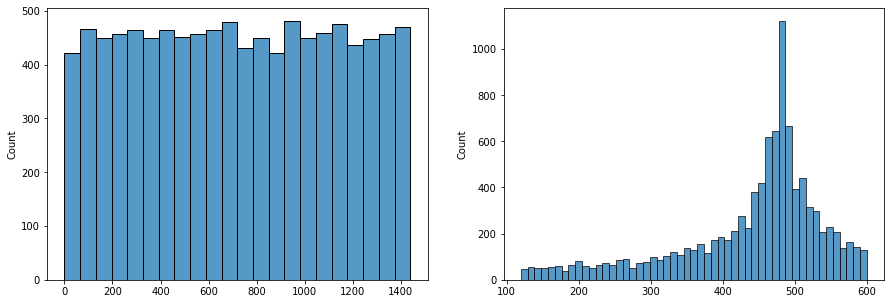

In [194]:
#check distribution of generated driver centers and intervals
dcenters, dintervals = generate_bundle(10000)

f, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(data = dcenters, ax = ax[0])
sns.histplot(data = dintervals, ax = ax[1])

In [195]:
#test generation
availability = np.zeros(1440)
preferred_availability = 2 * mm['Driver Count'].values
updated_avail, diff, accepted_dschedules = update_availability_arr(availability, generate_bundle(1000000),preferred_availability)

Transforming bounds to arrays:   0%|          | 0/1000000 [00:00<?, ?it/s]

Adding Drivers:   0%|          | 0/1000000 [00:00<?, ?it/s]

Total Drivers Accepted 44304


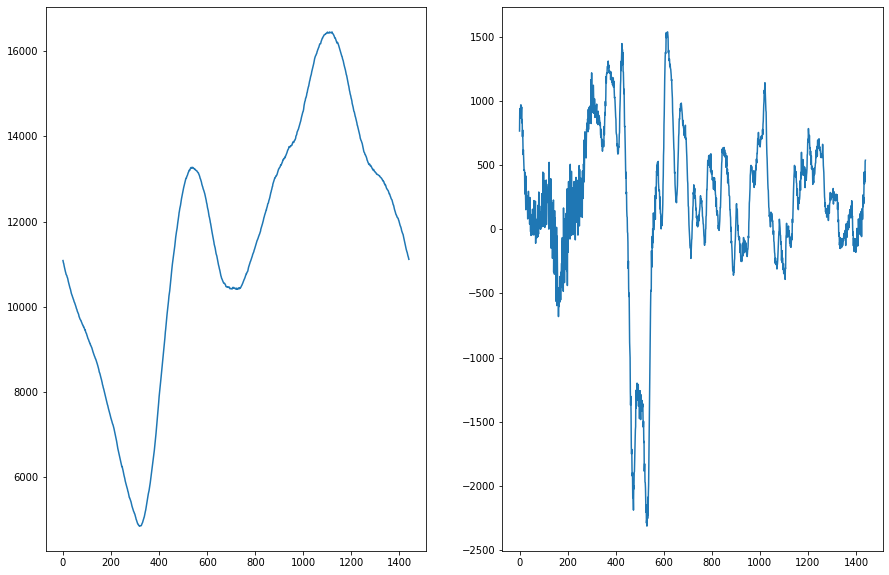

In [199]:
f, ax = plt.subplots(1, 2, figsize=(15,10))

print('Total Drivers Accepted', len(accepted_dschedules))
sns.lineplot(x = np.arange(1440), y = updated_avail, ax = ax[0])
_ = sns.lineplot(x = np.arange(1440), y = diff, ax = ax[1])


In [8]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_parquet('trip_time_means')
trip_time_data.head(3)

mean        std        min         max  count
pulocationid                                                      
1            1  19.037500  17.794296   2.716667   55.000000    8.0
             2   0.000000   0.000000   0.000000    0.000000    0.0
             3  54.540476  15.923260  34.650000  100.883333   14.0

In [9]:
from city_elements import *
from city import *
from event_list import *

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True,
                               show_progress_bar = False):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    iterable = zone_hourly_arrivals.index if not show_progress_bar else tqdm(zone_hourly_arrivals.index, position = 0, leave = True, desc = 'Zone Arrivals Generated')
    for i in iterable:
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        while temp_interarrivals.cumsum().max() <= 24 * 60:
            temp_interarrivals = np.append(temp_interarrivals, np.random.exponential(scale = 60/max_rate, size = 25000))
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        if len(arrival_df) > 0:
            services = [np.clip(np.random.normal(loc = info[0], scale = info[1]), info[2], info[3]) 
                        for info in zone_service_times.loc[arrival_df.dolocationid].values]

            arrival_df['service'] = services

            zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

def simulate_with_individual_drivers(arrivals,
                                     driver_distribution = 'proportional',
                                     driver_count = 10000,
                                     odmatrix = trip_time_data,
                                     pickup_data = hourly_arrival_rate):
    #convert arrivals into passengers, and then into events
    passengers = []
    drivers = []
    
    arrival_events = deque()
    for a in tqdm(arrivals.values, position = 0, leave = True, desc = 'Passenger Objects Created'):
        p = Passenger(a[0], a[1], a[2], a[3])
        passengers.append(p)
        arrival_events.append(Arrival(p))
    
    event_list = EventList(arrival_events)
    
    #setup drivers and zones based on driver_distribution parameter
    #everything is under the city class
    if driver_distribution == 'proportional':
        
        zones = []
        
        pbar = tqdm(total = driver_count, position = 0, leave = True, desc = 'Driver Objects Created')
        #number of drivers per zone
        #use the pickup data to do this
        arrivals_per_zone = pickup_data.sum(axis=1)
        dcounts = driver_count * (arrivals_per_zone / arrivals_per_zone.sum())
        dcounts = np.floor(dcounts)
        
        for i in range(1,264):
            if i in dcounts.index:
                temp_set = set()
                for j in range(int(dcounts.loc[i])):
                    d = Driver(i)
                    temp_set.add(d)
                    drivers.append(d)
                    pbar.update(1)
                zones.append(Zone(zone_id = i, driver_set = temp_set))
            else:
                zones.append(Zone(zone_id = i, driver_set = set()))
        
        for i in range(driver_count - len(drivers)):
            z = np.random.choice(np.arange(1,264))
            d = Driver(z)
            drivers.append(d)
            
            for zone in zones:
                if zone.zone == z:
                    zone.add_driver(d)
                    pbar.update(1)
                    break
                    
        city = City('NYC', zones, drivers, odmatrix)
            
    #iterate through the event list until no events left
    pbar = tqdm(total = arrivals.shape[0], position = 0, leave = True, desc = 'Passengers Processed')
    while not event_list.is_finished():
        
        event = event_list.iterate_next_event()

        result = city.process_event(event)
        if event.type == 'Trip':
            pbar.update(1)

        if result is not None:
            event_list.insert_event(result)    
                
    return passengers, drivers, city, event_list

def simulate_n_days(n,
                    driver_distribution = 'proportional',
                    driver_count = 15000):
    #just keep 1 driver history bc it takes up too much memory
    #keep all the waiting time information in dataframes
    passenger_details = []
    driver_history = None
    city_history = None
    
    for i in range(n):
        print(f'--- Day {i} ---')
        arrivals = generate_arrivals_per_zone(show_progress_bar=True)
        p, d, c, e = simulate_with_individual_drivers(arrivals, 
                                                      driver_distribution = driver_distribution, 
                                                      driver_count = driver_count)
        waiting_times = np.array([(pe.time, pe.start, pe.end, pe.service, pe.waiting_time()) for pe in p])
        waiting_times = pd.DataFrame(waiting_times, columns = ['arrival_time','starting zone', 'ending zone','service_time','waiting_time'])
        waiting_times['arrival_hour'] = waiting_times.arrival_time//60
        waiting_times['replication'] = i
        
        passenger_details.append(waiting_times)
        print(f'Average Waiting Time: {waiting_times.waiting_time.mean()}')
        print(f'Median Waiting Time: {np.median(waiting_times.waiting_time)}')
        print(f'Simulation System Speed: {e.formatted_stats()} \nMore stats: {c.formatted_stats()} \n --- End of Day {i} ---\n')
        
        if i == n - 1:
            driver_history = d
            city_history = c
    
    return pd.concat(passenger_details), driver_history, city_history